# Projecto Machine Learning

In [54]:
import matplotlib.pyplot as plt
import matplotlib; matplotlib.rcParams['figure.figsize'] = (13,6.6)
import numpy as np
import GPy
import pyGPs
from OX_database import DissolvedOxygenDatabase
from IPython.display import display
#GPy.plotting.change_plotting_library('plotly')

# Cargar base de datos

In [55]:
path = "/home/rodrigo/ml_prob/DissolvedOxygenPrediction/database/"
sequence_size = 3
train_prop = 0.75
first_day = [2007, 7, 1]

database = DissolvedOxygenDatabase(database_path=path,
                                   sequence_size=3,
                                   train_prop=train_prop,
                                   sequence_batch_size=50,
                                   start_date=first_day)

loading Dissolved_Oxygen
loading Temperature
loading pH
loading Electrical_Conductivity
loading River_Discharge


In [56]:
train_input, train_target, train_days = database.next_batch(batch_size="all")
train_target = train_target[..., np.newaxis]
max_days = float(np.amax(train_days))
print("Periodo: "+str(365/max_days))
train_days = train_days[..., np.newaxis]/max_days
test_input, test_target, test_days = database.next_batch(set="test")
test_target = test_target[..., np.newaxis]
test_days = test_days[..., np.newaxis]/max_days
print(train_target.shape, train_days.shape)

Periodo: 0.205056179775
((1661, 1), (1661, 1))


## Relación entre variables

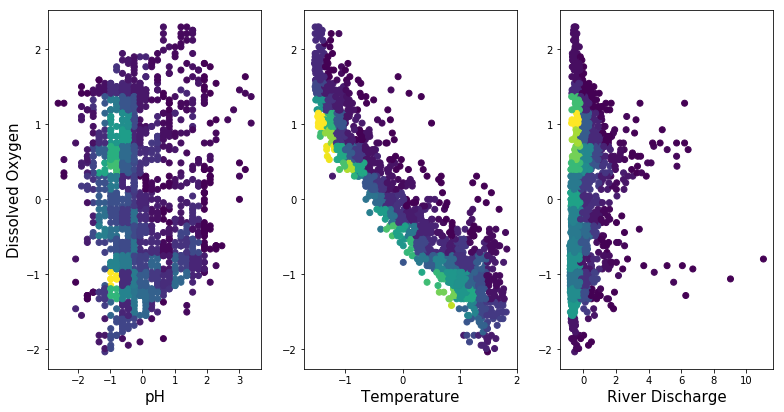

In [57]:
t_target = train_target[:, 0]
n_points = 20

f, axarr = plt.subplots(1,3)
xedges, yedges = np.linspace(np.amin(train_input[:, 0]), np.amax(train_input[:, 0]), n_points), np.linspace(-2, 2, n_points)
hist, xedges, yedges = np.histogram2d(train_input[:, 0], t_target, (xedges, yedges))
xidx = np.clip(np.digitize(train_input[:, 0], xedges), 0, hist.shape[0]-1)
yidx = np.clip(np.digitize(t_target, yedges), 0, hist.shape[1]-1)
c = hist[xidx, yidx]
sc = axarr[0].scatter(train_input[:, 0], t_target, c=c)
#plt.colorbar(sc, orientation='horizontal')
axarr[0].set_xlabel("pH", fontsize=15)
axarr[0].set_ylabel("Dissolved Oxygen", fontsize=15)

xedges, yedges = np.linspace(np.amin(train_input[:, 1]), np.amax(train_input[:, 1]), n_points), np.linspace(-2, 2, n_points)
hist, xedges, yedges = np.histogram2d(train_input[:, 1], t_target, (xedges, yedges))
xidx = np.clip(np.digitize(train_input[:, 1], xedges), 0, hist.shape[0]-1)
yidx = np.clip(np.digitize(t_target, yedges), 0, hist.shape[1]-1)
c = hist[xidx, yidx]
sc = axarr[1].scatter(train_input[:, 1], t_target, c=c)
#plt.colorbar(sc, orientation='horizontal')
axarr[1].set_xlabel("Temperature", fontsize=15)

xedges, yedges = np.linspace(np.amin(train_input[:, 2]), np.amax(train_input[:, 2]), n_points), np.linspace(-2, 2, n_points)
hist, xedges, yedges = np.histogram2d(train_input[:, 2], t_target, (xedges, yedges))
xidx = np.clip(np.digitize(train_input[:, 2], xedges), 0, hist.shape[0]-1)
yidx = np.clip(np.digitize(t_target, yedges), 0, hist.shape[1]-1)
c = hist[xidx, yidx]
sc = axarr[2].scatter(train_input[:, 2], t_target, c=c)
#plt.colorbar(sc, orientation='horizontal')
axarr[2].set_xlabel("River Discharge", fontsize=15)
plt.savefig("data_relations.png")
plt.show()

In [58]:
def plot_mean_std(ax, x_train, x_test, train_mean, test_mean, train_std, test_std, train_real, test_real):
    ax.plot(x_train, train_mean, "b", label = "GP train", lw=2)
    ax.fill_between(x_train, train_mean+2*train_std, train_mean-2*train_std, alpha = 0.3)
    ax.plot(x_train, train_real, 'kx', alpha=0.4, ms = 3)
    ax.plot(x_test, test_mean, "g", label = "GP train", lw=2)
    ax.fill_between(x_test, test_mean+2*test_std, test_mean-2*test_std, alpha = 0.3, facecolor='green')
    ax.plot(x_test, test_real, 'rx', alpha=0.4, ms=3)
    ax.set_xlim([np.amin(x_train), np.amax(x_test)])
    ax.set_ylim([-2,2])
    
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, sharex=True, sharey=True)
f.subplots_adjust(hspace=0)
plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

## DO

In [59]:
periodic_kernel1 = GPy.kern.PeriodicExponential(input_dim=1, period=0.820879382699, lengthscale=0.0474594918672,
                                                variance=18.4806648375)
DO_model = GPy.models.GPRegression(train_days, train_target, periodic_kernel1)
DO_model.Gaussian_noise = 0.0931445863634
mu_train, var_train = DO_model.predict(train_days)
mu_test, var_test = DO_model.predict(test_days)
var_train = np.sqrt(var_train)[:,0]
var_test = np.sqrt(var_test)[:,0]
plot_mean_std(ax1, train_days[:,0], test_days[:,0], mu_train[:,0], mu_test[:,0], var_train, var_test,
             train_target[:,0], test_target[:,0])
ax1.set_ylabel("DO", fontsize=15)
ax1.tick_params(labelsize=14)
display(DO_model)

GP_regression.,value,constraints,priors
periodic_exponential.variance,18.4806648375,+ve,
periodic_exponential.lengthscale,0.0474594918672,+ve,
periodic_exponential.period,0.820879382699,+ve,
Gaussian_noise.variance,0.0931445863634,+ve,


## pH

In [60]:
periodic_kernel2 = GPy.kern.PeriodicExponential(input_dim=1, period=0.785739524702, lengthscale=0.0126529286097,
                                                variance=10.6922709426)
ph_model = GPy.models.GPRegression(train_days, train_input[:, 0][..., np.newaxis], periodic_kernel2)
ph_model.Gaussian_noise = 0.583673661263
mu_train, var_train = ph_model.predict(train_days)
mu_test, var_test = ph_model.predict(test_days)
var_train = np.sqrt(var_train)[:,0]
var_test = np.sqrt(var_test)[:,0]
plot_mean_std(ax2, train_days[:,0], test_days[:,0], mu_train[:,0], mu_test[:,0], var_train, var_test,
             train_input[:, 0], test_input[:,0])
ax2.set_ylabel("pH", fontsize=15)
ax2.tick_params(labelsize=14)
display(ph_model)

GP_regression.,value,constraints,priors
periodic_exponential.variance,10.6922709426,+ve,
periodic_exponential.lengthscale,0.0126529286097,+ve,
periodic_exponential.period,0.785739524702,+ve,
Gaussian_noise.variance,0.583673661263,+ve,


## Temperatura

In [61]:
periodic_kernel3 = GPy.kern.PeriodicExponential(input_dim=1, period=0.820879382699, lengthscale=0.0197976647724,
                                                variance=19.2364211292)
temp_model = GPy.models.GPRegression(train_days, train_input[:, 1][..., np.newaxis], periodic_kernel3)
temp_model.Gaussian_noise = 0.0358275394171
mu_train, var_train = temp_model.predict(train_days)
mu_test, var_test = temp_model.predict(test_days)
var_train = np.sqrt(var_train)[:,0]
var_test = np.sqrt(var_test)[:,0]
plot_mean_std(ax3, train_days[:,0], test_days[:,0], mu_train[:,0], mu_test[:,0], var_train, var_test,
             train_input[:, 1], test_input[:,1])
ax3.set_ylabel("Temp", fontsize=15)
ax3.tick_params(labelsize=14)
display(temp_model)

GP_regression.,value,constraints,priors
periodic_exponential.variance,19.2364211292,+ve,
periodic_exponential.lengthscale,0.0197976647724,+ve,
periodic_exponential.period,0.820879382699,+ve,
Gaussian_noise.variance,0.0358275394171,+ve,


In [62]:
periodic_kernel4 = GPy.kern.PeriodicExponential(input_dim=1, period=1.05099286013, lengthscale=0.0238005156243,
                                                variance=6.58984162137)
temp_model = GPy.models.GPRegression(train_days, train_input[:, 2][..., np.newaxis], periodic_kernel4)
temp_model.Gaussian_noise = 0.695143446575
mu_train, var_train = temp_model.predict(train_days)
mu_test, var_test = temp_model.predict(test_days)
var_train = np.sqrt(var_train)[:,0]
var_test = np.sqrt(var_test)[:,0]
plot_mean_std(ax4, train_days[:,0], test_days[:,0], mu_train[:,0], mu_test[:,0], var_train, var_test,
             train_input[:, 2], test_input[:,2])
ax4.set_ylabel("RD", fontsize=15)
ax4.tick_params(labelsize=14)
ax4.set_xlabel("Tiempo (dias normalizados)", fontsize=15)
display(temp_model)
plt.savefig("all_f_fore.png")


GP_regression.,value,constraints,priors
periodic_exponential.variance,6.58984162137,+ve,
periodic_exponential.lengthscale,0.0238005156243,+ve,
periodic_exponential.period,1.05099286013,+ve,
Gaussian_noise.variance,0.695143446575,+ve,
